# 針對 sentence similarity 進行比較

## 導入資料集

In [2]:
import pandas as pd

str = pd.read_csv('sem_text_rel_ranked.csv')

row = str.loc[0]
sent1, sent2 = row['Text'].split("\n")
score = row['Score']


print(sent1,"<->",sent2," => ",score)


It that happens, just pull the plug. <-> if that ever happens, just pull the plug.  =>  1.0


## 導入套件

In [37]:
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from nltk import pos_tag

# 下载nltk资源（如果尚未下载）
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\USER\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\USER\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\USER\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

## 導入模型

In [36]:

from gensim.models import KeyedVectors


# 加载预训练的 Word2Vec 模型
model = KeyedVectors.load_word2vec_format('../model/GoogleNews-vectors-negative300.bin.gz', binary=True)

## woed2vec + TFIDF

In [38]:
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
# 读取数据
df = pd.read_csv('sem_text_rel_ranked.csv')

# 初始化 TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer(stop_words=None)  # 設置 stop_words=None 檢查是否解決問題

# 定义函数计算基于 TF-IDF 的句子向量
def sentence_to_vec(sentence, model, tfidf_vector, feature_names):
    words = sentence.split()
    word_vectors = []
    for word in words:
        if word in model.key_to_index and word in feature_names:
            index = feature_names.tolist().index(word)
            tfidf_weight = tfidf_vector[index]
            word_vectors.append(model[word] * tfidf_weight)
    if len(word_vectors) == 0:
        return np.zeros(model.vector_size)
    sentence_vector = np.mean(word_vectors, axis=0)
    return sentence_vector

# 处理每一对句子
results = []
for index, row in df.iterrows():
    sentences = row['Text'].split("\n")
    actual_similarity_score = row['Score']
    if len(sentences) < 2:
        continue  # 如果没有两个句子就跳过

    # 向量化句子
    try:
        tfidf_matrix = tfidf_vectorizer.fit_transform(sentences)
        feature_names = tfidf_vectorizer.get_feature_names_out()

        # 计算句子向量
        sentence_vectors = [
            sentence_to_vec(sentence, model, tfidf_matrix[i].toarray().flatten(), feature_names)
            for i, sentence in enumerate(sentences)
        ]

        # 计算余弦相似度
        cosine_sim = cosine_similarity([sentence_vectors[0]], [sentence_vectors[1]])[0][0]

        # 存儲結果
        results.append({
            'index': index,
            'sentence_1': sentences[0],
            'sentence_2': sentences[1],
            'calculated_similarity': cosine_sim,
            'actual_similarity': actual_similarity_score
        })
    except ValueError as e:
        print(f"Error processing row {index}: {e}")

# 输出结果
results_df = pd.DataFrame(results)
print(results_df)

results_df.to_csv("sts/TFIDF_1.txt",index=False)
import numpy as np
import pandas as pd
from scipy.stats import spearmanr as sp

# 假设 results_df 是您上面已经创建好的包含结果的 DataFrame

print(sp(results_df['calculated_similarity'],results_df['actual_similarity']))


Error processing row 5493: empty vocabulary; perhaps the documents only contain stop words
      index                                         sentence_1  \
0         0               It that happens, just pull the plug.   
1         1                 A black dog running through water.   
2         2       I've been searchingthe entire abbey for you.   
3         3  If he is good looking and has a good personali...   
4         4  She does not hate you, she is just annoyed wit...   
...     ...                                                ...   
5494   5495                  A young boy pounding on an anvil.   
5495   5496  I love how he recognized his wife tempered his...   
5496   5497  I actually read a chapter or two beyond that p...   
5497   5498       A boy gives being in the snow two thumbs up.   
5498   5499  Perhaps it is strange to think about sex const...   

                                             sentence_2  \
0             if that ever happens, just pull the plug.  

In [39]:
import numpy as np
import pandas as pd
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from gensim.models import KeyedVectors

# 加载预训练的 Word2Vec 模型
# model = KeyedVectors.load_word2vec_format('../model/GoogleNews-vectors-negative300.bin.gz', binary=True)

# 读取数据
df = pd.read_csv('sem_text_rel_ranked.csv')

# 初始化 TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer(stop_words=None)  # 设置 stop_words=None 检查是否解决问题

# 定义函数清洗和处理文本
def clean_text(text):
    # 将文本转换为小写并移除所有非字母字符
    text = re.sub(r'[^\w\s]', '', text.lower())
    return text

# 定义函数计算基于 TF-IDF 的句子向量
def sentence_to_vec(sentence, model, tfidf_vector, feature_names):
    words = sentence.split()
    word_vectors = []
    for word in words:
        if word in model.key_to_index and word in feature_names:
            index = feature_names.tolist().index(word)
            tfidf_weight = tfidf_vector[index]
            word_vectors.append(model[word] * tfidf_weight)
    if len(word_vectors) == 0:
        return np.zeros(model.vector_size)
    sentence_vector = np.mean(word_vectors, axis=0)
    return sentence_vector

# 处理每一对句子
results = []
for index, row in df.iterrows():
    sentences = [clean_text(s) for s in row['Text'].split("\n")]
    actual_similarity_score = row['Score']
    if len(sentences) < 2:
        continue  # 如果没有两个句子就跳过

    # 向量化句子
    try:
        tfidf_matrix = tfidf_vectorizer.fit_transform(sentences)
        feature_names = tfidf_vectorizer.get_feature_names_out()

        # 计算句子向量
        sentence_vectors = [
            sentence_to_vec(sentence, model, tfidf_matrix[i].toarray().flatten(), feature_names)
            for i, sentence in enumerate(sentences)
        ]

        # 计算余弦相似度
        cosine_sim = cosine_similarity([sentence_vectors[0]], [sentence_vectors[1]])[0][0]

        # 存储结果
        results.append({
            'index': index,
            'sentence_1': sentences[0],
            'sentence_2': sentences[1],
            'calculated_similarity': cosine_sim,
            'actual_similarity': actual_similarity_score
        })
    except ValueError as e:
        print(f"Error processing row {index}: {e}")

# 输出结果
results_df = pd.DataFrame(results)
print(results_df)

# 保存结果
results_df.to_csv("sts/TDIDF_2.txt", index=False)
import numpy as np
import pandas as pd
from scipy.stats import spearmanr as sp

# 假设 results_df 是您上面已经创建好的包含结果的 DataFrame

print(sp(results_df['calculated_similarity'],results_df['actual_similarity']))

Error processing row 5493: empty vocabulary; perhaps the documents only contain stop words
      index                                         sentence_1  \
0         0                 it that happens just pull the plug   
1         1                  a black dog running through water   
2         2         ive been searchingthe entire abbey for you   
3         3  if he is good looking and has a good personali...   
4         4  she does not hate you she is just annoyed with...   
...     ...                                                ...   
5494   5495                   a young boy pounding on an anvil   
5495   5496  i love how he recognized his wife tempered his...   
5496   5497  i actually read a chapter or two beyond that p...   
5497   5498        a boy gives being in the snow two thumbs up   
5498   5499  perhaps it is strange to think about sex const...   

                                             sentence_2  \
0               if that ever happens just pull the plug  

In [40]:

import numpy as np
import pandas as pd
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from gensim.models import KeyedVectors
# 初始化词形还原器
lemmatizer = WordNetLemmatizer()

# 定义函数将nltk标记转换为WordNet标记
def nltk_pos_to_wordnet_pos(nltk_pos):
    if nltk_pos.startswith('J'):
        return wordnet.ADJ
    elif nltk_pos.startswith('V'):
        return wordnet.VERB
    elif nltk_pos.startswith('N'):
        return wordnet.NOUN
    elif nltk_pos.startswith('R'):
        return wordnet.ADV
    else:
        return None

# 定义函数清洗和处理文本
def clean_text(text):
    # 将文本转换为小写并移除所有非字母字符
    text = re.sub(r'[^\w\s]', '', text.lower())
    # 分词
    words = nltk.word_tokenize(text)
    # 词性标注
    tagged_words = pos_tag(words)
    # 词形还原
    lemmatized_words = [
        lemmatizer.lemmatize(word, pos=nltk_pos_to_wordnet_pos(pos_tag))
        if nltk_pos_to_wordnet_pos(pos_tag) is not None else word
        for word, pos_tag in tagged_words
    ]
    return ' '.join(lemmatized_words)

# 加载预训练的 Word2Vec 模型
# model = KeyedVectors.load_word2vec_format('../model/GoogleNews-vectors-negative300.bin.gz', binary=True)

# 读取数据
df = pd.read_csv('sem_text_rel_ranked.csv')

# 初始化 TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer(stop_words=None)  # 设置 stop_words=None 检查是否解决问题

# 处理每一对句子
results = []
for index, row in df.iterrows():
    sentences = [clean_text(s) for s in row['Text'].split("\n")]
    actual_similarity_score = row['Score']
    if len(sentences) < 2:
        continue  # 如果没有两个句子就跳过

    # 向量化句子
    try:
        tfidf_matrix = tfidf_vectorizer.fit_transform(sentences)
        feature_names = tfidf_vectorizer.get_feature_names_out()

        # 计算句子向量
        sentence_vectors = [
            sentence_to_vec(sentence, model, tfidf_matrix[i].toarray().flatten(), feature_names)
            for i, sentence in enumerate(sentences)
        ]

        # 计算余弦相似度
        cosine_sim = cosine_similarity([sentence_vectors[0]], [sentence_vectors[1]])[0][0]

        # 存储结果
        results.append({
            'index': index,
            'sentence_1': sentences[0],
            'sentence_2': sentences[1],
            'calculated_similarity': cosine_sim,
            'actual_similarity': actual_similarity_score
        })
    except ValueError as e:
        print(f"Error processing row {index}: {e}")

# 输出结果
results_df = pd.DataFrame(results)
print(results_df)

# 保存结果
results_df.to_csv("sts/TFIDF_3.txt", index=False)

import numpy as np
import pandas as pd
from scipy.stats import spearmanr as sp

# 假设 results_df 是您上面已经创建好的包含结果的 DataFrame

print(sp(results_df['calculated_similarity'],results_df['actual_similarity']))

Error processing row 5493: empty vocabulary; perhaps the documents only contain stop words
      index                                         sentence_1  \
0         0                  it that happen just pull the plug   
1         1                      a black dog run through water   
2         2           ive be searchingthe entire abbey for you   
3         3  if he be good look and have a good personality...   
4         4     she do not hate you she be just annoy with you   
...     ...                                                ...   
5494   5495                      a young boy pound on an anvil   
5495   5496  i love how he recognize his wife temper his da...   
5496   5497  i actually read a chapter or two beyond that p...   
5497   5498             a boy give be in the snow two thumb up   
5498   5499  perhaps it be strange to think about sex const...   

                                             sentence_2  \
0                if that ever happen just pull the plug  

## woed2vec 

In [41]:
import numpy as np
import pandas as pd
from gensim.models import KeyedVectors
from sklearn.metrics.pairwise import cosine_similarity

# 加载预训练的 Word2Vec 模型
# model = KeyedVectors.load_word2vec_format('../model/GoogleNews-vectors-negative300.bin.gz', binary=True)

# 读取数据
df = pd.read_csv('sem_text_rel_ranked.csv')

# 定义函数计算基于 Word2Vec 的句子向量
def sentence_to_vec(sentence, model):
    words = sentence.split()
    word_vectors = [model[word] for word in words if word in model.key_to_index]
    if len(word_vectors) == 0:
        return np.zeros(model.vector_size)
    sentence_vector = np.mean(word_vectors, axis=0)
    return sentence_vector

# 处理每一对句子
results = []
for index, row in df.iterrows():
    sentences = row['Text'].split("\n")
    actual_similarity_score = row['Score']
    if len(sentences) < 2:
        continue  # 如果没有两个句子就跳过

    # 计算句子向量
    try:
        sentence_vectors = [sentence_to_vec(sentence, model) for sentence in sentences]

        # 计算余弦相似度
        cosine_sim = cosine_similarity([sentence_vectors[0]], [sentence_vectors[1]])[0][0]

        # 存储结果
        results.append({
            'index': index,
            'sentence_1': sentences[0],
            'sentence_2': sentences[1],
            'calculated_similarity': cosine_sim,
            'actual_similarity': actual_similarity_score
        })
    except Exception as e:
        print(f"Error processing row {index}: {e}")

# 输出结果
results_df = pd.DataFrame(results)
print(results_df)

# 保存结果
results_df.to_csv("sts/word2vec_1.txt", index=False)


import numpy as np
import pandas as pd
from scipy.stats import spearmanr as sp

# 假设 results_df 是您上面已经创建好的包含结果的 DataFrame

print(sp(results_df['calculated_similarity'],results_df['actual_similarity']))

      index                                         sentence_1  \
0         0               It that happens, just pull the plug.   
1         1                 A black dog running through water.   
2         2       I've been searchingthe entire abbey for you.   
3         3  If he is good looking and has a good personali...   
4         4  She does not hate you, she is just annoyed wit...   
...     ...                                                ...   
5495   5495                  A young boy pounding on an anvil.   
5496   5496  I love how he recognized his wife tempered his...   
5497   5497  I actually read a chapter or two beyond that p...   
5498   5498       A boy gives being in the snow two thumbs up.   
5499   5499  Perhaps it is strange to think about sex const...   

                                             sentence_2  \
0             if that ever happens, just pull the plug.   
1            A black dog is running through some water.   
2               I'm looking fo

In [42]:
import numpy as np
import pandas as pd
import re
from gensim.models import KeyedVectors
from sklearn.metrics.pairwise import cosine_similarity

# 加载预训练的 Word2Vec 模型
# model = KeyedVectors.load_word2vec_format('../model/GoogleNews-vectors-negative300.bin.gz', binary=True)

# 读取数据
df = pd.read_csv('sem_text_rel_ranked.csv')

# 定义函数处理文本：去除标点符号和转换为小写
def clean_text(text):
    return re.sub(r'[^\w\s]', '', text.lower())

# 定义函数计算基于 Word2Vec 的句子向量
def sentence_to_vec(sentence, model):
    words = sentence.split()
    word_vectors = [model[word] for word in words if word in model.key_to_index]
    if len(word_vectors) == 0:
        return np.zeros(model.vector_size)
    sentence_vector = np.mean(word_vectors, axis=0)
    return sentence_vector

# 处理每一对句子
results = []
for index, row in df.iterrows():
    sentences = [clean_text(s) for s in row['Text'].split("\n")]
    actual_similarity_score = row['Score']
    if len(sentences) < 2:
        continue  # 如果没有两个句子就跳过

    # 计算句子向量
    try:
        sentence_vectors = [sentence_to_vec(sentence, model) for sentence in sentences]

        # 计算余弦相似度
        cosine_sim = cosine_similarity([sentence_vectors[0]], [sentence_vectors[1]])[0][0]

        # 存储结果
        results.append({
            'index': index,
            'sentence_1': sentences[0],
            'sentence_2': sentences[1],
            'calculated_similarity': cosine_sim,
            'actual_similarity': actual_similarity_score
        })
    except Exception as e:
        print(f"Error processing row {index}: {e}")

# 输出结果
results_df = pd.DataFrame(results)
print(results_df)

# 保存结果
results_df.to_csv("sts/word2vec_2.txt", index=False)

# 计算斯皮尔曼相关系数
from scipy.stats import spearmanr
correlation, p_value = spearmanr(results_df['calculated_similarity'], results_df['actual_similarity'])
print("Spearman Correlation Coefficient:", correlation)
print("P-Value:", p_value)

      index                                         sentence_1  \
0         0                 it that happens just pull the plug   
1         1                  a black dog running through water   
2         2         ive been searchingthe entire abbey for you   
3         3  if he is good looking and has a good personali...   
4         4  she does not hate you she is just annoyed with...   
...     ...                                                ...   
5495   5495                   a young boy pounding on an anvil   
5496   5496  i love how he recognized his wife tempered his...   
5497   5497  i actually read a chapter or two beyond that p...   
5498   5498        a boy gives being in the snow two thumbs up   
5499   5499  perhaps it is strange to think about sex const...   

                                             sentence_2  \
0               if that ever happens just pull the plug   
1             a black dog is running through some water   
2                 im looking f

In [43]:
import numpy as np
import pandas as pd
import re
from gensim.models import KeyedVectors
from sklearn.metrics.pairwise import cosine_similarity
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet


# 加载预训练的 Word2Vec 模型
# model = KeyedVectors.load_word2vec_format('../model/GoogleNews-vectors-negative300.bin.gz', binary=True)

# 读取数据
df = pd.read_csv('sem_text_rel_ranked.csv')

# 初始化詞形還原器
lemmatizer = WordNetLemmatizer()

# 定义函数获取 NLTK 的词性
def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

# 定义函数处理文本：去除标点符号，转换为小写，并进行词形还原
def clean_text(text):
    text = re.sub(r'[^\w\s]', '', text.lower())
    tokens = nltk.word_tokenize(text)
    tagged = nltk.pos_tag(tokens)
    return ' '.join([lemmatizer.lemmatize(word, get_wordnet_pos(tag)) for word, tag in tagged])

# 定义函数计算基于 Word2Vec 的句子向量
def sentence_to_vec(sentence, model):
    words = sentence.split()
    word_vectors = [model[word] for word in words if word in model.key_to_index]
    if len(word_vectors) == 0:
        return np.zeros(model.vector_size)
    sentence_vector = np.mean(word_vectors, axis=0)
    return sentence_vector

# 处理每一对句子
results = []
for index, row in df.iterrows():
    sentences = [clean_text(s) for s in row['Text'].split("\n")]
    actual_similarity_score = row['Score']
    if len(sentences) < 2:
        continue  # 如果没有两个句子就跳过

    # 计算句子向量
    try:
        sentence_vectors = [sentence_to_vec(sentence, model) for sentence in sentences]

        # 计算余弦相似度
        cosine_sim = cosine_similarity([sentence_vectors[0]], [sentence_vectors[1]])[0][0]

        # 存储结果
        results.append({
            'index': index,
            'sentence_1': sentences[0],
            'sentence_2': sentences[1],
            'calculated_similarity': cosine_sim,
            'actual_similarity': actual_similarity_score
        })
    except Exception as e:
        print(f"Error processing row {index}: {e}")

# 输出结果
results_df = pd.DataFrame(results)
print(results_df)

# 保存结果
results_df.to_csv("sts/word2vec_3.txt", index=False)

# 计算斯皮尔曼相关系数
from scipy.stats import spearmanr
correlation, p_value = spearmanr(results_df['calculated_similarity'], results_df['actual_similarity'])
print("Spearman Correlation Coefficient:", correlation)
print("P-Value:", p_value)


      index                                         sentence_1  \
0         0                  it that happen just pull the plug   
1         1                      a black dog run through water   
2         2           ive be searchingthe entire abbey for you   
3         3  if he be good look and have a good personality...   
4         4     she do not hate you she be just annoy with you   
...     ...                                                ...   
5495   5495                      a young boy pound on an anvil   
5496   5496  i love how he recognize his wife temper his da...   
5497   5497  i actually read a chapter or two beyond that p...   
5498   5498             a boy give be in the snow two thumb up   
5499   5499  perhaps it be strange to think about sex const...   

                                             sentence_2  \
0                if that ever happen just pull the plug   
1                 a black dog be run through some water   
2                    im look f

## GPT-2

In [23]:
import torch
from transformers import GPT2Model, GPT2Tokenizer
from sklearn.metrics.pairwise import cosine_similarity
import pandas as pd
from scipy.stats import spearmanr

# 加载 GPT-2 模型和分词器
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
model = GPT2Model.from_pretrained('gpt2')

# 定義函數以獲得句子的嵌入向量
def get_sentence_embedding(sentence):
    inputs = tokenizer(sentence, return_tensors='pt')
    outputs = model(**inputs)
    hidden_states = outputs.last_hidden_state
    sentence_embedding = hidden_states.mean(dim=1).detach().numpy()
    return sentence_embedding

# 讀取数据
df = pd.read_csv('sem_text_rel_ranked.csv')

results = []
for index, row in df.iterrows():
    sentences = row['Text'].split("\n")
    actual_similarity_score = row['Score']
    if len(sentences) < 2:
        continue

    # 獲取每个句子的嵌入向量
    try:
        vec1 = get_sentence_embedding(sentences[0])
        vec2 = get_sentence_embedding(sentences[1])
        
        # 計算餘弦相似度
        cosine_sim = cosine_similarity(vec1, vec2)[0][0]
        
        # 存儲结果
        results.append({
            'index': index,
            'sentence_1': sentences[0],
            'sentence_2': sentences[1],
            'calculated_similarity': cosine_sim,
            'actual_similarity': actual_similarity_score
        })
    except Exception as e:
        print(f"Error processing row {index}: {e}")

# 輸出和保存結果
results_df = pd.DataFrame(results)
print(results_df)

# 計算斯皮爾曼相关系数
correlation, p_value = spearmanr(results_df['calculated_similarity'], results_df['actual_similarity'])
print("Spearman Correlation Coefficient:", correlation)
print("P-Value:", p_value)

# 保存到文件
results_df.to_csv("sts_gpt2.txt", index=False)


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

c:\Users\USER\AppData\Local\Programs\Python\Python310\lib\site-packages\huggingface_hub\file_download.py:157: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\USER\.cache\huggingface\hub\models--gpt2. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

c:\Users\USER\AppData\Local\Programs\Python\Python310\lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

      index                                         sentence_1  \
0         0               It that happens, just pull the plug.   
1         1                 A black dog running through water.   
2         2       I've been searchingthe entire abbey for you.   
3         3  If he is good looking and has a good personali...   
4         4  She does not hate you, she is just annoyed wit...   
...     ...                                                ...   
5495   5495                  A young boy pounding on an anvil.   
5496   5496  I love how he recognized his wife tempered his...   
5497   5497  I actually read a chapter or two beyond that p...   
5498   5498       A boy gives being in the snow two thumbs up.   
5499   5499  Perhaps it is strange to think about sex const...   

                                             sentence_2  \
0             if that ever happens, just pull the plug.   
1            A black dog is running through some water.   
2               I'm looking fo

## BERT 

In [29]:
import pandas as pd
import re
from sentence_transformers import SentenceTransformer, util
from scipy.stats import spearmanr

# 加載預訓练的 SentenceTransformer 模型
model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')

# 定義函数處理文本：去除標點符號和轉换為小寫
def clean_text(text):
    return re.sub(r'[^\w\s]', '', text.lower())

# 讀取數據
df = pd.read_csv('sem_text_rel_ranked.csv')

results = []
for index, row in df.iterrows():
    sentences = [clean_text(s) for s in row['Text'].split("\n")]
    actual_similarity_score = row['Score']
    if len(sentences) < 2:
        continue

    # 獲取每个句子的嵌入向量
    try:
        embedding_1 = model.encode(sentences[0], convert_to_tensor=True)
        embedding_2 = model.encode(sentences[1], convert_to_tensor=True)
        
        # 計算余弦相似度
        cosine_sim = util.pytorch_cos_sim(embedding_1, embedding_2).item()
        
        # 存儲結果
        results.append({
            'index': index,
            'sentence_1': sentences[0],
            'sentence_2': sentences[1],
            'calculated_similarity': cosine_sim,
            'actual_similarity': actual_similarity_score
        })
    except Exception as e:
        print(f"Error processing row {index}: {e}")

# 輸出和保存结果
results_df = pd.DataFrame(results)
print(results_df.head())  # 打印前几行進行检查

# 检查是否成功生成了 'calculated_similarity' 列
if 'calculated_similarity' in results_df.columns and 'actual_similarity' in results_df.columns:
    # 计算斯皮尔曼相关系数
    correlation, p_value = spearmanr(results_df['calculated_similarity'], results_df['actual_similarity'])
    print("Spearman Correlation Coefficient:", correlation)
    print("P-Value:", p_value)

    # 保存到文件
    results_df.to_csv("sts_sentence_transformers.txt", index=False)
else:
    print("Error: 'calculated_similarity' or 'actual_similarity' column is missing.")

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

c:\Users\USER\AppData\Local\Programs\Python\Python310\lib\site-packages\huggingface_hub\file_download.py:157: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\USER\.cache\huggingface\hub\models--sentence-transformers--all-MiniLM-L6-v2. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

c:\Users\USER\AppData\Local\Programs\Python\Python310\lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

   index                                         sentence_1  \
0      0                 it that happens just pull the plug   
1      1                  a black dog running through water   
2      2         ive been searchingthe entire abbey for you   
3      3  if he is good looking and has a good personali...   
4      4  she does not hate you she is just annoyed with...   

                                          sentence_2  calculated_similarity  \
0            if that ever happens just pull the plug               0.903674   
1          a black dog is running through some water               0.980841   
2              im looking for you all over the abbey               0.830264   
3  if hes good looking and a good personality he ...               0.945368   
4            she doesnt hate you she is just annoyed               0.979259   

   actual_similarity  
0                1.0  
1                1.0  
2                1.0  
3                1.0  
4                1.0  
Spearman

## 使用預先準備的movie plot，以bert進行相似度分析

In [45]:
import pandas as pd
df = pd.read_csv('../IMDB/IMDB_Top250Engmovies2_OMDB_Detailed.csv')
df.head()

,Unnamed: 0,Title,Year,Rated,Released,Runtime,Genre,Director,Writer,Actors,...,tomatoConsensus,tomatoUserMeter,tomatoUserRating,tomatoUserReviews,tomatoURL,DVD,BoxOffice,Production,Website,Response
0,1,The Shawshank Redemption,1994,R,14 Oct 1994,142 min,"Crime, Drama",Frank Darabont,"Stephen King (short story ""Rita Hayworth and S...","Tim Robbins, Morgan Freeman, Bob Gunton, Willi...",...,NaN,NaN,NaN,NaN,http://www.rottentomatoes.com/m/shawshank_rede...,27 Jan 1998,NaN,Columbia Pictures,NaN,True
1,2,The Godfather,1972,R,24 Mar 1972,175 min,"Crime, Drama",Francis Ford Coppola,"Mario Puzo (screenplay), Francis Ford Coppola ...","Marlon Brando, Al Pacino, James Caan, Richard ...",...,NaN,NaN,NaN,NaN,http://www.rottentomatoes.com/m/godfather/,09 Oct 2001,NaN,Paramount Pictures,http://www.thegodfather.com,True
2,3,The Godfather: Part II,1974,R,20 Dec 1974,202 min,"Crime, Drama",Francis Ford Coppola,"Francis Ford Coppola (screenplay), Mario Puzo ...","Al Pacino, Robert Duvall, Diane Keaton, Robert...",...,NaN,NaN,NaN,NaN,http://www.rottentomatoes.com/m/godfather_part...,24 May 2005,NaN,Paramount Pictures,http://www.thegodfather.com/,True
3,4,The Dark Knight,2008,PG-13,18 Jul 2008,152 min,"Action, Crime, Drama",Christopher Nolan,"Jonathan Nolan (screenplay), Christopher Nolan...","Christian Bale, Heath Ledger, Aaron Eckhart, M...",...,NaN,NaN,NaN,NaN,http://www.rottentomatoes.com/m/the_dark_knight/,09 Dec 2008,"$533,316,061",Warner Bros. Pictures/Legendary,http://thedarkknight.warnerbros.com/,True
4,5,12 Angry Men,1957,APPROVED,01 Apr 1957,96 min,"Crime, Drama",Sidney Lumet,"Reginald Rose (story), Reginald Rose (screenplay)","Martin Balsam, John Fiedler, Lee J. Cobb, E.G....",...,NaN,NaN,NaN,NaN,http://www.rottentomatoes.com/m/1000013-12_ang...,06 Mar 2001,NaN,Criterion Collection,http://www.criterion.com/films/27871-12-angry-men,True


### 基於情節(plot)進行整理

In [46]:
# to remove punctuations from Plot

from rake_nltk import Rake

# 移除標點符號
df['Plot'] = df['Plot'].str.replace('[^ws]','')
Plot = df["Plot"]
df['Key_words'] = ''   # initializing a new column
r = Rake()   # using Rake to remove stop words

for index, row in df.iterrows():
    r.extract_keywords_from_text(row['Plot'])
    key_words_dict_scores = r.get_word_degrees()
    df.at[index, 'Key_words'] = list(key_words_dict_scores.keys())

print(df['Key_words'])

0      [two, imprisoned, men, bond, number, years, fi...
1      [aging, patriarch, organized, crime, dynasty, ...
2      [early, life, career, vito, corleone, 1920s, n...
3      [menace, known, joker, emerges, mysterious, pa...
4      [jury, holdout, attempts, prevent, miscarriage...
                             ...                        
245    [desperate, life, chronic, alcoholic, followed...
246    [20, something, supervising, staff, member, re...
247    [newspaper, editor, uses, every, trick, book, ...
248    [old, man, makes, long, journey, lawn, mover, ...
249    [mumbai, teen, reflects, upbringing, slums, ac...
Name: Key_words, Length: 250, dtype: object


In [48]:
import pandas as pd
import re
from sentence_transformers import SentenceTransformer, util
from scipy.stats import spearmanr
import numpy as np

# 加载预训练的 SentenceTransformer 模型
model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')

# 定义函数处理文本：去除标点符号和转换为小写
def clean_text(text):
    return re.sub(r'[^\w\s]', '', text.lower())

# 读取数据

# 清理并转换 'Key_words2' 列中的文本

df['Key_words_joined'] = df['Key_words'].apply(lambda x: ' '.join(x))
df['Key_words_joined'] = df['Key_words_joined'].apply(clean_text)

# 获取每个句子的嵌入向量
embeddings = model.encode(df['Key_words_joined'].tolist(), convert_to_tensor=True)

# 创建存储相似度矩阵
cosine_sim_matrix = np.zeros((len(embeddings), len(embeddings)))

# 计算每对句子的余弦相似度
for i in range(len(embeddings)):
    for j in range(len(embeddings)):
        cosine_sim_matrix[i, j] = util.pytorch_cos_sim(embeddings[i], embeddings[j]).item()

# 保存相似度矩阵到文件
np.savetxt("sts/cosine_similarity_matrix.txt", cosine_sim_matrix, fmt="%f")

# 打印前几行进行检查
print(cosine_sim_matrix[:5, :5])

c:\Users\USER\AppData\Local\Programs\Python\Python310\lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


[[1.         0.26608935 0.13785848 0.14567845 0.18288586]
 [0.26608935 1.00000012 0.39777046 0.14579472 0.03968604]
 [0.13785848 0.39777046 1.00000012 0.24266261 0.02539758]
 [0.14567845 0.14579472 0.24266261 1.         0.09679182]
 [0.18288586 0.03968604 0.02539758 0.09679182 1.00000012]]


In [49]:
import pandas as pd
import re
from sentence_transformers import SentenceTransformer, util
import numpy as np

# 加载预训练的 SentenceTransformer 模型
model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')

# 定义函数处理文本：去除标点符号和转换为小写
def clean_text(text):
    return re.sub(r'[^\w\s]', '', text.lower())

# 清理并转换 'Key_words2' 列中的文本
df['Key_words_joined'] = df['Key_words'].apply(lambda x: ' '.join(x))
df['Key_words_joined'] = df['Key_words_joined'].apply(clean_text)

# 获取每个句子的嵌入向量
embeddings = model.encode(df['Key_words_joined'].tolist(), convert_to_tensor=True)

# 将嵌入向量保存到文件中
np.save('sts/movie_embeddings.npy', embeddings.cpu().numpy())

c:\Users\USER\AppData\Local\Programs\Python\Python310\lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [1]:
import numpy as np

# 讀取txt檔案
cosine_sim_matrix = np.loadtxt('matrix/sentence_transformers_cosine_similarity_matrix.txt')
print(cosine_sim_matrix)

[[1.       0.266089 0.137858 ... 0.144303 0.185403 0.18161 ]
 [0.266089 1.       0.39777  ... 0.092052 0.248535 0.241845]
 [0.137858 0.39777  1.       ... 0.150863 0.128789 0.1608  ]
 ...
 [0.144303 0.092052 0.150863 ... 1.       0.186039 0.120742]
 [0.185403 0.248535 0.128789 ... 0.186039 1.       0.137882]
 [0.18161  0.241845 0.1608   ... 0.120742 0.137882 1.      ]]


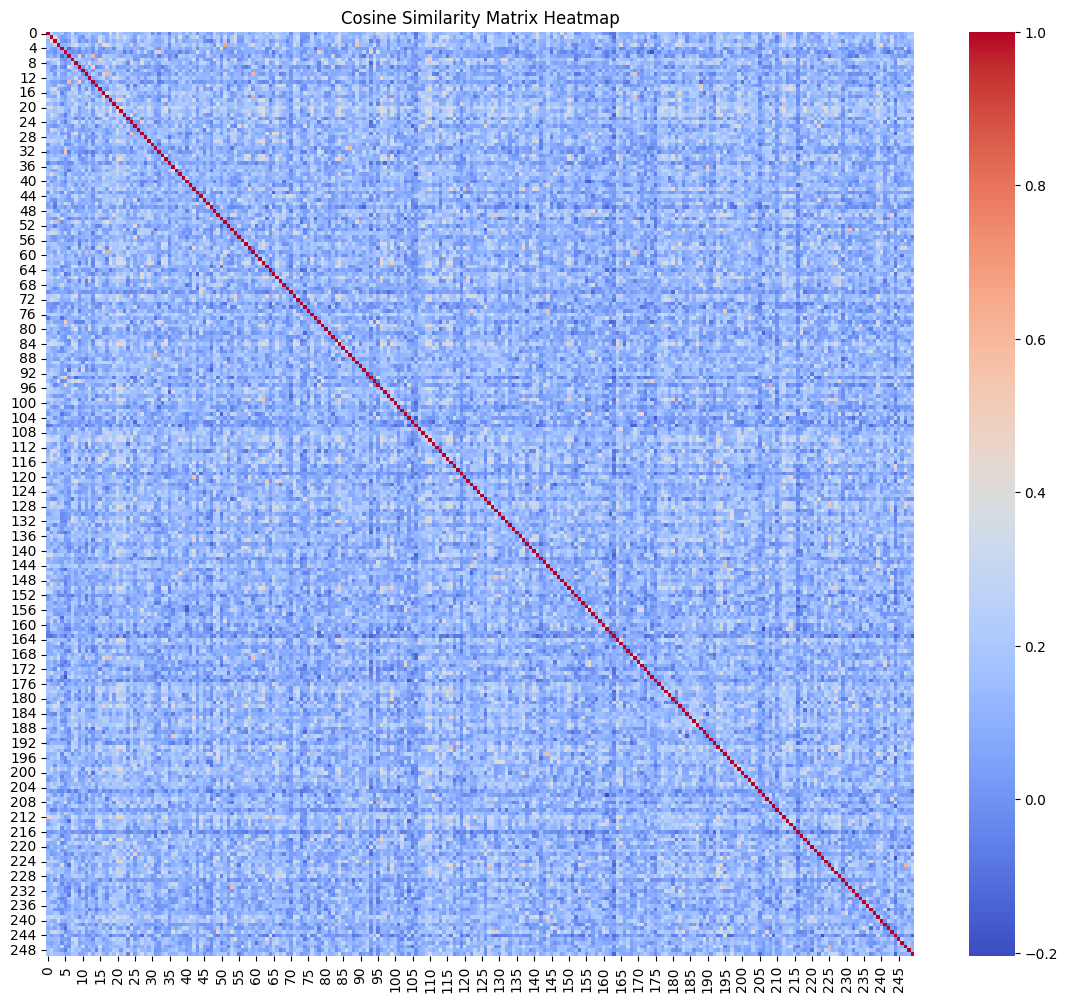

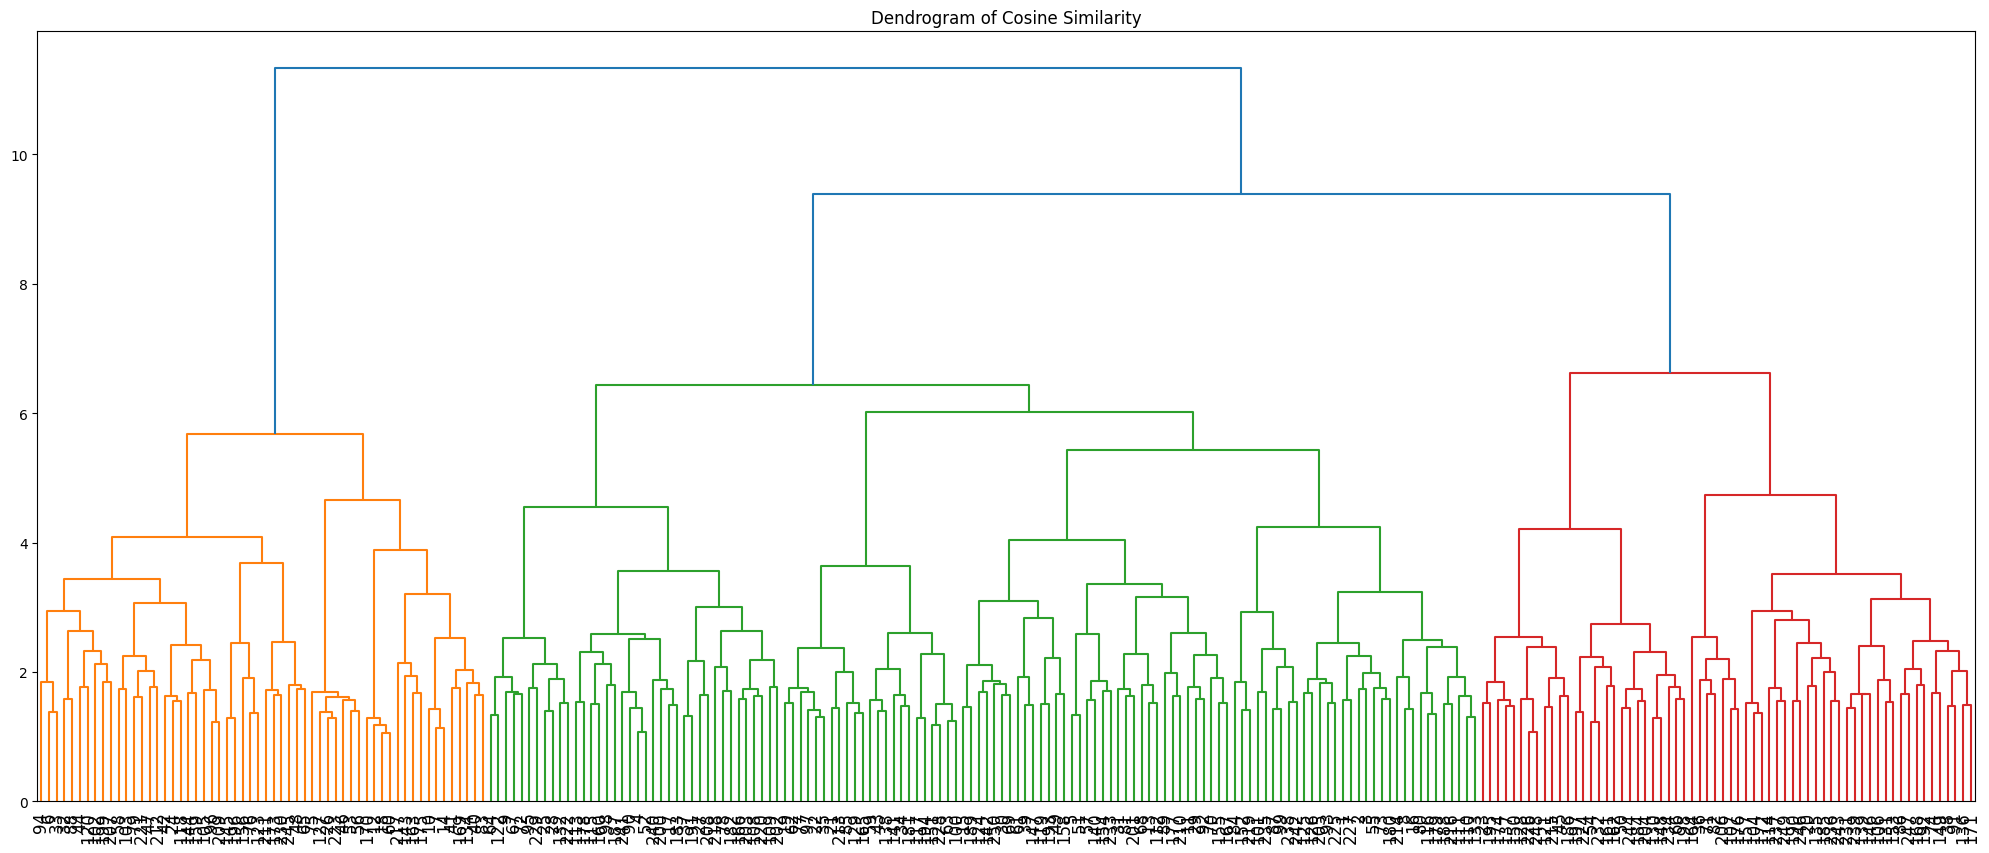

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.metrics.pairwise import cosine_similarity



# 使用 Seaborn 绘制热力图
plt.figure(figsize=(14, 12))
sns.heatmap(cosine_sim_matrix, cmap='coolwarm')
plt.title("Cosine Similarity Matrix Heatmap")
plt.show()

# 使用 SciPy 进行层次聚类，并绘制树状图
linked = linkage(cosine_sim_matrix, 'ward')  # 使用最小距离方法

# 确保标签数量正确
num_docs = cosine_sim_matrix.shape[0]
labels = [f"{i+1}" for i in range(num_docs)]

plt.figure(figsize=(25, 10))
dendrogram(linked, labels=labels, leaf_rotation=90, leaf_font_size=12,color_threshold=linked[-(3-1), 2] )
plt.title("Dendrogram of Cosine Similarity")
plt.show()

c:\Users\USER\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\USER\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\USER\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\USER\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\

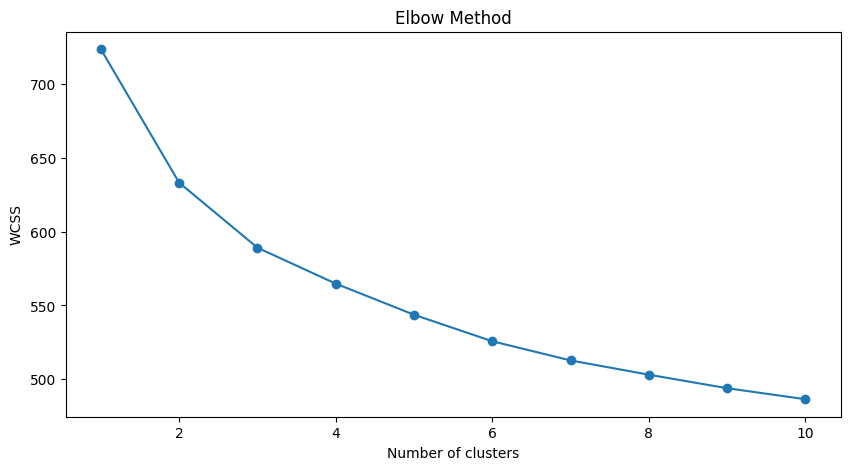

c:\Users\USER\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\USER\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\USER\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\USER\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\

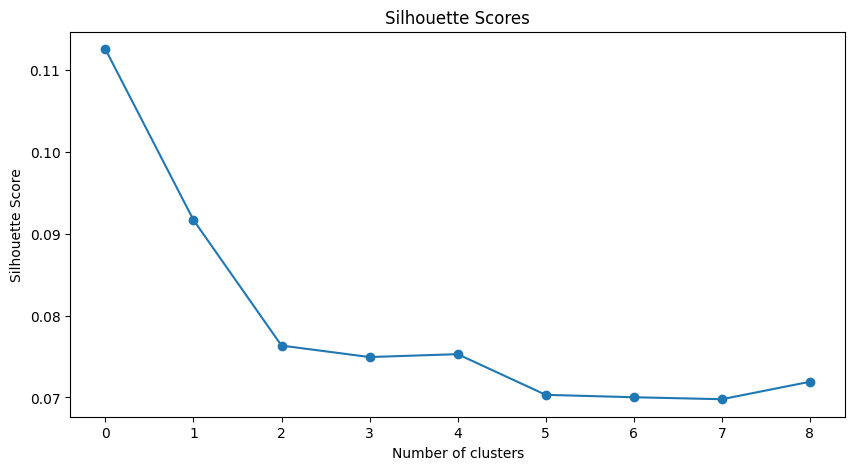

In [3]:
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

# 生成一些樣本數據
np.random.seed(42)
data = np.random.rand(100, 2)

# 肘部法則
wcss = []
max_clusters = 10
for i in range(1, max_clusters + 1):
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(cosine_sim_matrix)
    wcss.append(kmeans.inertia_)

plt.figure(figsize=(10, 5))
plt.plot(range(1, max_clusters + 1), wcss, marker='o')
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

# 輪廓係數
silhouette_scores = []
for i in range(2, max_clusters + 1):
    kmeans = KMeans(n_clusters=i, random_state=42)
    cluster_labels = kmeans.fit_predict(cosine_sim_matrix)
    silhouette_avg = silhouette_score(cosine_sim_matrix, cluster_labels)
    silhouette_scores.append(silhouette_avg)

plt.figure(figsize=(10, 5))
plt.plot(silhouette_scores, marker='o')
plt.title('Silhouette Scores')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.show()